In [ ]:
!pip install tensorflow_datasets

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/ec2-user/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


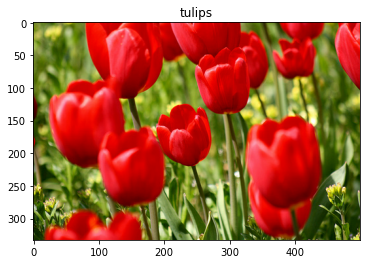

In [6]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [7]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

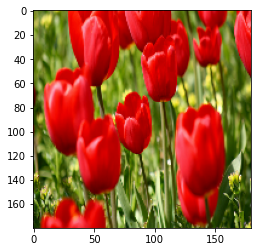

In [8]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

print( type(image), image.shape )

<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 333, 500, 3)


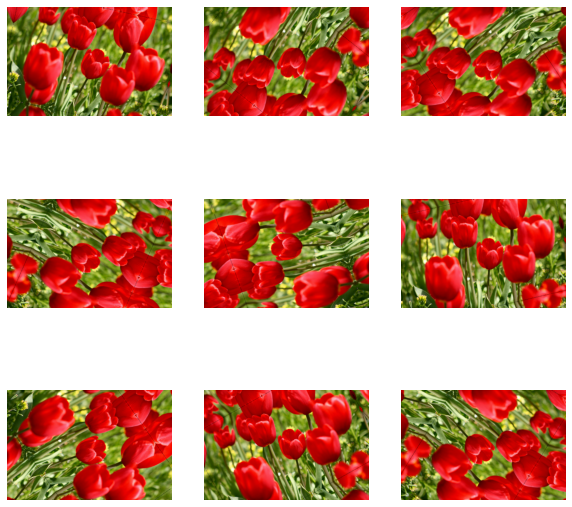

In [11]:
plt.figure(figsize=(10, 10))

for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [14]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [16]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 95s 1s/step - loss: 1.3290 - accuracy: 0.4237 - val_loss: 1.1981 - val_accuracy: 0.4796
Epoch 2/5
92/92 [==============================] - 88s 955ms/step - loss: 1.0970 - accuracy: 0.5409 - val_loss: 1.0915 - val_accuracy: 0.5831
Epoch 3/5
92/92 [==============================] - 90s 976ms/step - loss: 1.0035 - accuracy: 0.5964 - val_loss: 1.0037 - val_accuracy: 0.6076
Epoch 4/5
92/92 [==============================] - 88s 951ms/step - loss: 0.9432 - accuracy: 0.6240 - val_loss: 1.0090 - val_accuracy: 0.5967
Epoch 5/5
92/92 [==============================] - 88s 958ms/step - loss: 0.8780 - accuracy: 0.6495 - val_loss: 0.8618 - val_accuracy: 0.6512


In [20]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 296ms/step - loss: 0.8247 - accuracy: 0.6812
Accuracy 0.6811988949775696
